In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/GAN'
%ls

/content/drive/My Drive/GAN


In [ ]:
%tensorflow_version 1.x
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pylab as plt
from math import ceil
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, ReLU, LeakyReLU, Dense
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.initializers import RandomNormal

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
def build_generator(z_dim = 128, n_filter = 64):
    
    init = RandomNormal(stddev=0.02)
    
    G = Sequential()
    G.add(Dense(2*2*n_filter*8, input_shape=(z_dim,), use_bias=True, kernel_initializer=init))
    
    # 2*2*512
    G.add(Reshape((2,2,n_filter*8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 4*4*256
    G.add(Conv2DTranspose(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 8*8*128
    G.add(Conv2DTranspose(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 16*16*64
    G.add(Conv2DTranspose(n_filter, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 32*32*3
    G.add(Conv2DTranspose(3, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    
    print('Build Generator')
    print(G.summary())
    
    return G

In [ ]:
def build_discriminator(input_shape=(32,32,3), n_filter=64):
    
    init = RandomNormal(stddev=0.02)
    
    D = Sequential()
    
    # 16*16*64
    D.add(Conv2D(n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(LeakyReLU(0.2))
    
    # 8*8*64
    D.add(Conv2D(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 4*4*64
    D.add(Conv2D(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 2*2*64
    D.add(Conv2D(n_filter*8, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    D.add(Flatten())
    D.add(Dense(1, kernel_initializer=init))
    D.add(Activation('sigmoid'))
    
    print('Build discriminator')
    print(D.summary())
    
    return D

In [ ]:
def get_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    X_train = 2*(X_train/255)-1
    X_test = 2*(X_train/255)-1
    
    return X_train, X_test

In [ ]:
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images + 1) / 2. * 255.
    images = images.astype(np.uint8)
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    #plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    plt.imshow(images)
    plt.show()

In [ ]:
def plot_losses(losses_d, losses_g, filename): 
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    #plt.close()

In [ ]:
def train(n_filter=64, z_dim=100, lr_d=2e-4, lr_g=2e-4, epochs=300, batch_size=128,     
          epoch_per_checkpoint=1, n_checkpoint_images=36, verbose=10):
    X_train,_ = get_data()
    image_shape = X_train[0].shape
    print('Image shape {}, min val {}, max val {}'.format(image_shape, np.min(X_train[0]), np.max(X_train[0])))
    
    plot_images(X_train[:n_checkpoint_images], 'real_image.png')
    
    # Build model
    G = build_generator(z_dim, n_filter)
    D = build_discriminator(image_shape, n_filter)
    
    # Loss for discriminator
    D.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # D(G(X))
    D.trainable = False
    z = Input(shape=(z_dim,))
    D_of_G = Model(inputs=z, outputs=D(G(z)))
    
    # Loss for generator
    D_of_G.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # Labels for computing the losses
    real_labels = np.ones(shape=(batch_size, 1))
    fake_labels = np.zeros(shape=(batch_size, 1))
    losses_d, losses_g = [], []
    
    # fix a z vector for training evaluation
    z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
    
    for e in tqdm(range(1, epochs+1)):
        n_steps = X_train.shape[0]//batch_size
        for i in range(n_steps):
            # Train discriminator
            D.trainable = True
            real_images = X_train[i*batch_size:(i+1)*batch_size]
            loss_d_real = D.train_on_batch(x=real_images, y=real_labels)[0]
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            fake_images = G.predict_on_batch(z)
            loss_d_fake = D.train_on_batch(x=fake_images, y=fake_labels)[0]
            
            loss_d = loss_d_real + loss_d_fake
            
            # Train generator
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=real_labels)[0]
            
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            
            if i == 0 and e%verbose == 0:
                print('Epoch {}'.format(e))
                fake_images = G.predict(z_fixed)
                #print("\tPlotting images and losses")
                plot_images(fake_images, "Images/fake_images_e_{}.png".format(e))
                #plot_losses(losses_d, losses_g, "losses.png")

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


170500096/170498071 [==============================] - 2s 0us/step
Image shape (32, 32, 3), min val -1.0, max val 1.0


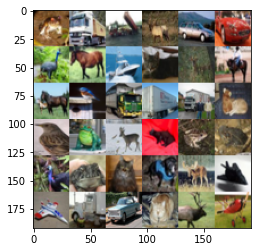

Build Generator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4,

Epoch 10


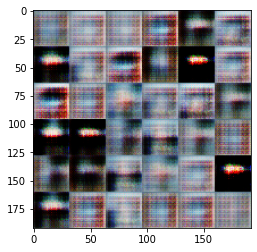

Epoch 20


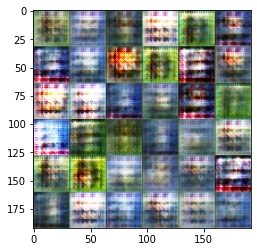

Epoch 30


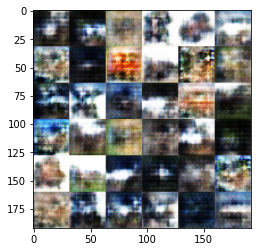

Epoch 40


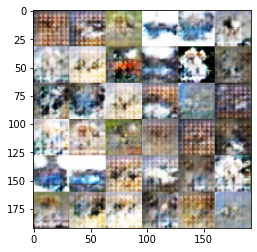

Epoch 50


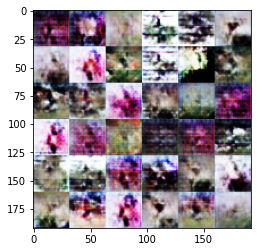

Epoch 60


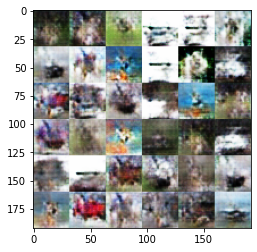

Epoch 70


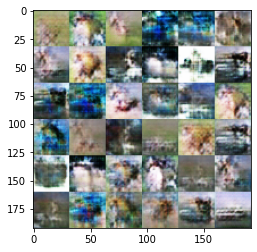

Epoch 80


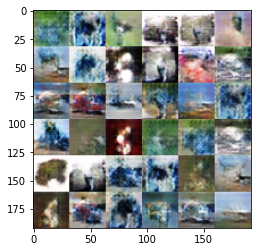

Epoch 90


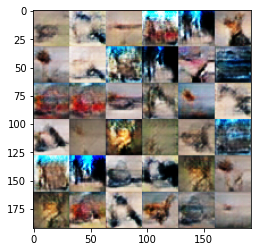

Epoch 100


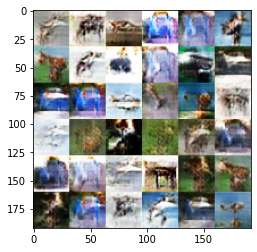

Epoch 110


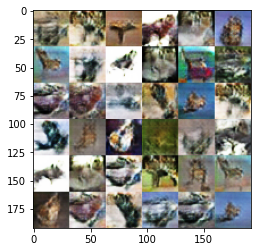

Epoch 120


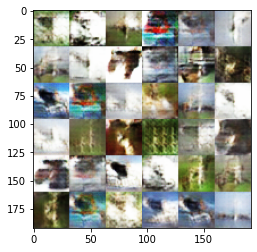

Epoch 130


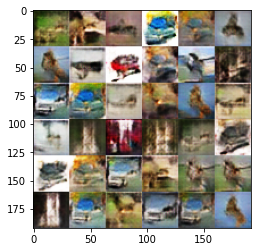

Epoch 140


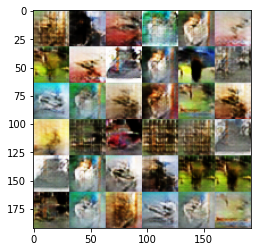

Epoch 150


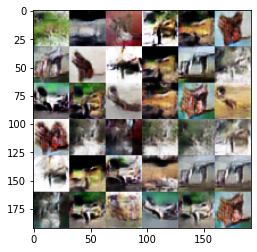

Epoch 160


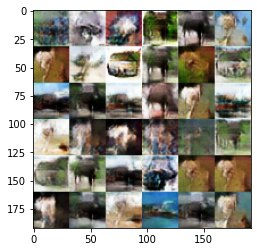

Epoch 170


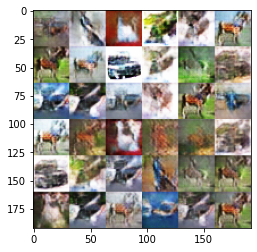

Epoch 180


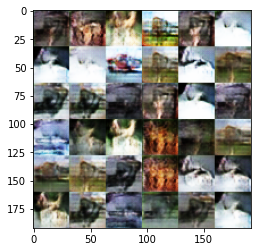

Epoch 190


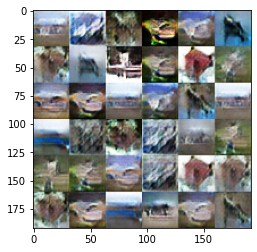

Epoch 200


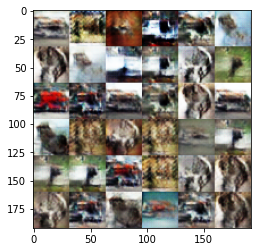

Epoch 210


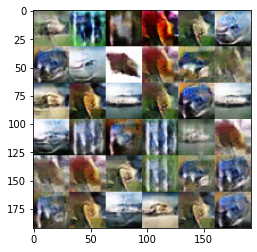

Epoch 220


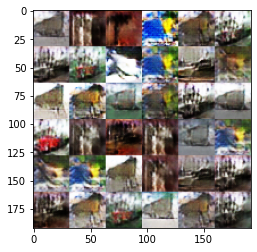

Epoch 230


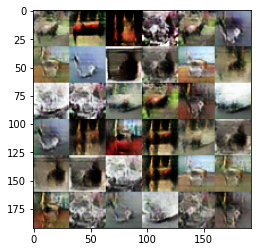

Epoch 240


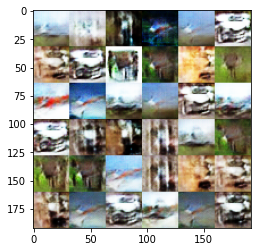

Epoch 250


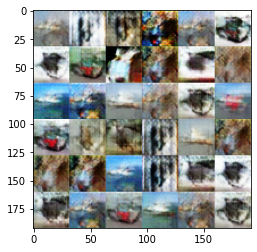

Epoch 260


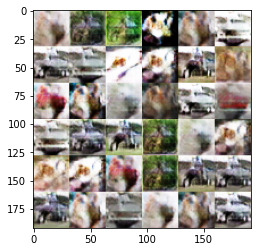

Epoch 270


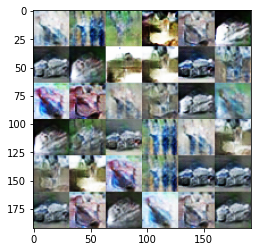

Epoch 280


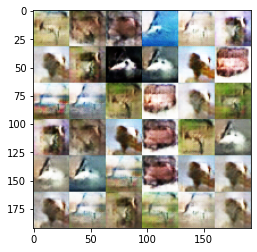

Epoch 290


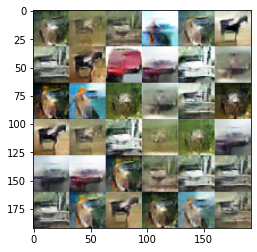

Epoch 300


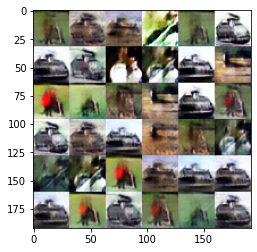

In [ ]:
train()